In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from matplotlib import lines
import utils as ut
import m_models as mm
import os
from tqdm import tqdm_notebook as tqdm

import pylab

import statsmodels.api as sm

import scipy.stats as sps
from scipy.optimize import minimize_scalar as minimize_scalar

import pickle

from sklearn.linear_model import Lasso

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']= 36
plt.rcParams['axes.labelsize']= 40
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

---

In [3]:
N = 10
M = 1000
sigma = 1

bootstrap_num_iter = 1000

---
Генерируем выборку

In [4]:
w = sps.uniform().rvs(N)

X = sps.norm(loc=0, scale=1).rvs(size=(M, N))
y = X @ w + sps.norm(loc=0, scale=sigma).rvs(size=M)

/home/coder/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/coder/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2004: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


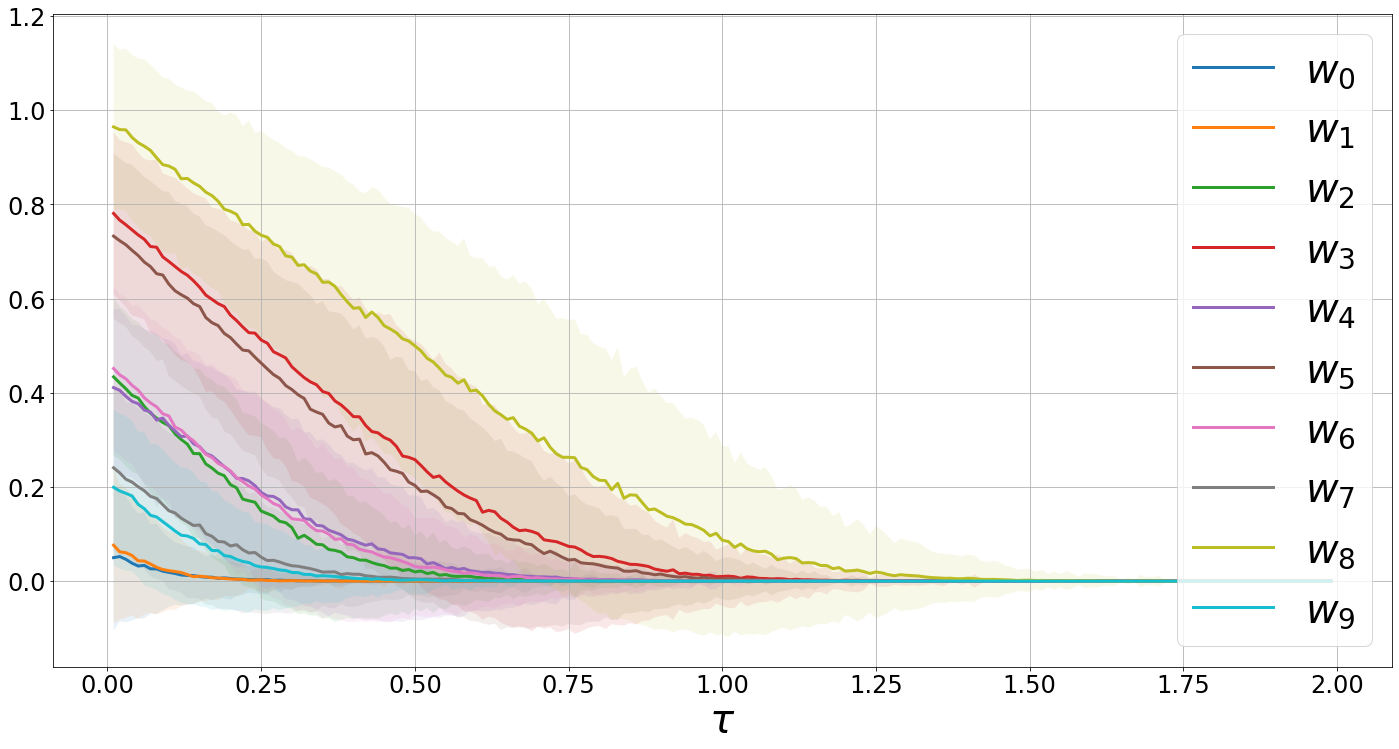

In [5]:
m_0 = 100
W = []
W_std = []

alphas = np.arange(0.01, 2, 0.01)

for alpha in tqdm(alphas):
    
    w_hats = []
    
    for i in range(bootstrap_num_iter):
        
        idx = np.random.choice(M, size=m_0)
        
        X_cur = X[idx]
        y_cur = y[idx]
        
        cur_model = Lasso(alpha=alpha)
        cur_model.fit(X_cur, y_cur)
        w_hats.append(cur_model.coef_)
    
    W.append(np.mean(w_hats, axis=0))
    W_std.append(np.std(w_hats, axis=0))
    
W = np.asarray(W)
W_std = np.asarray(W_std)

for i in range(N):
    plt.plot(alphas, W[:, i], label='$w_{' + str(i) + '}$')
    plt.fill_between(alphas, sps.norm(loc=W[:, i], scale=W_std[:, i]).ppf(0.05), sps.norm(loc=W[:, i], scale=W_std[:, i]).ppf(0.95),
                 alpha=0.1)

plt.xlabel('$\\tau$')
plt.legend()
plt.grid()
# plt.savefig('../data/pics/synthetic_lasso_W.pdf', format='pdf')
plt.show()

---
Запомним те $\alpha$, при которых обнуляется очередной коэффициент

In [6]:
alpha_threshold = []

for i in range(N):
    alpha_threshold.append((alphas[np.argmax(W[:, i] < 0.05)], i))
    
alpha_threshold = sorted(alpha_threshold)
alpha_threshold = np.asarray([[t[0], t[1]] for t in alpha_threshold])

---
Построим зависимость функции ошибки от объема выборки при разном количестве признаков

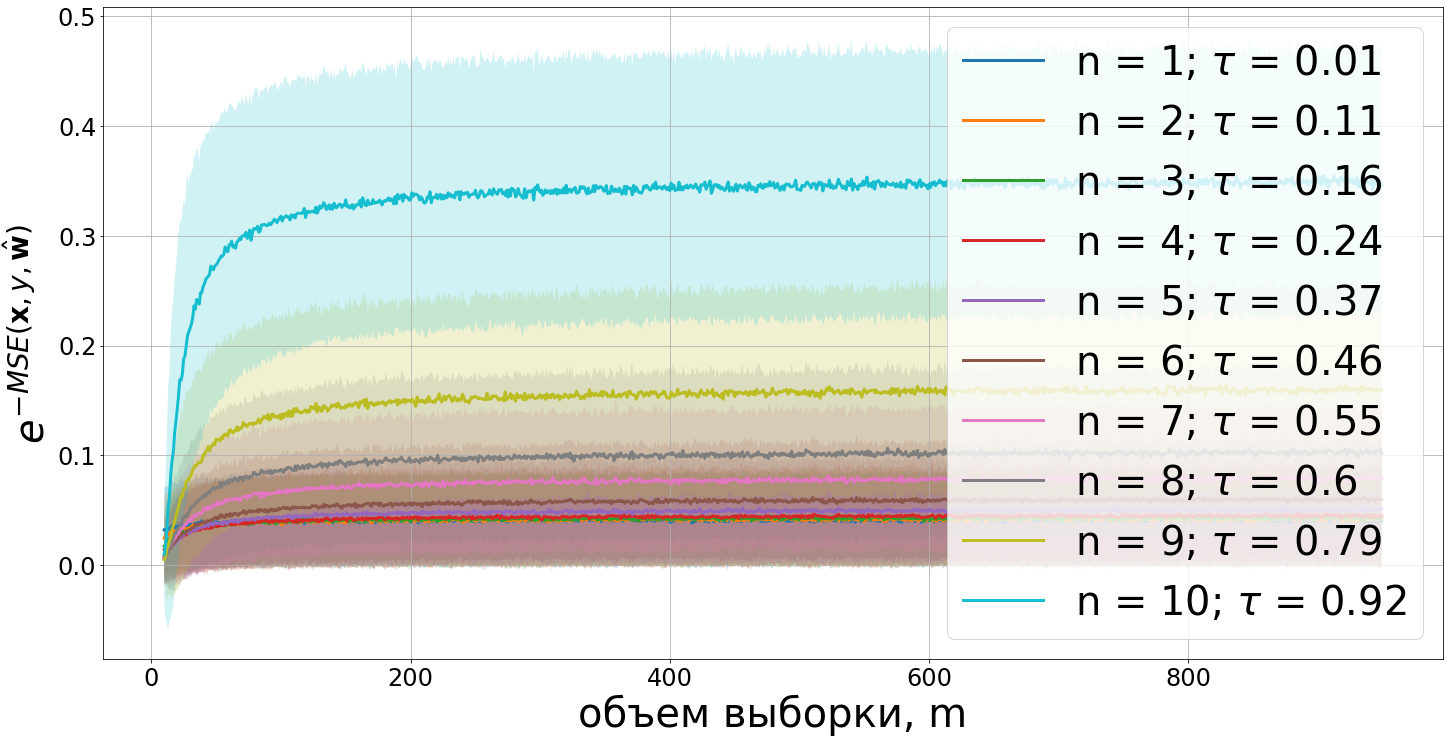

In [34]:
S = []
std = []

test_size = 50

for j in tqdm(range(N)):

    S_cur = []
    std_cur = []
    
    X_j = X[:, alpha_threshold[:j + 1, 1].astype(np.int32)]
    y_j = y

    for m_0 in range(10, M - test_size):

        mse = []

        for i in range(bootstrap_num_iter):

            idx = np.random.choice(M, size=m_0 + test_size, replace=False)

            X_cur = X_j[idx]
            y_cur = y_j[idx]
            
            X_train = X_cur[:-test_size]
            y_train = y_cur[:-test_size]
            X_test = X_cur[-test_size:]
            y_test = y_cur[-test_size:]

            w_hat = ut.get_params(X_train, y_train)
#             mse.append(np.mean((X_test @ w_hat - y_test) ** 2))
            mse.append(np.exp(-np.mean((X_test @ w_hat - y_test) ** 2)))

        S_cur.append(np.mean(mse))
        std_cur.append(np.std(mse))

    S_cur = np.asarray(S_cur)
    std_cur = np.asarray(std_cur)
    
    S.append(S_cur)
    std.append(std_cur)

    plt.plot(np.arange(10, M - test_size), S[j], label='n = {}'.format(j + 1) + '; $\\tau$ = {}'.format(round(alpha_threshold[j, 0], 2)))
    plt.fill_between(np.arange(10, M - test_size), sps.norm(loc=S[j], scale=std[j]).ppf(0.05), sps.norm(loc=S[j], scale=std[j]).ppf(0.95),
                     alpha=0.2)
    
S = np.asarray(S)
std = np.asarray(std)

plt.xlabel('объем выборки, m')
plt.ylabel('$e^{-MSE(\mathbf{x}, y, \hat{\mathbf{w}})}$')
plt.legend(loc='lower right')
plt.grid()
    
# plt.savefig('../data/pics/synthetic_MSE_n.pdf', format='pdf')

plt.show()

In [35]:
X_axis = np.arange(N)
Y_axis = np.arange(20, M - test_size)
XX, YY = np.meshgrid(X_axis, Y_axis)
ZZ = S[:, 10:].T
ZZ_down = sps.norm(loc=S[:, 10:].T, scale=std[:, 10:].T).ppf(0.05)
ZZ_up = sps.norm(loc=S[:, 10:].T, scale=std[:, 10:].T).ppf(0.95)

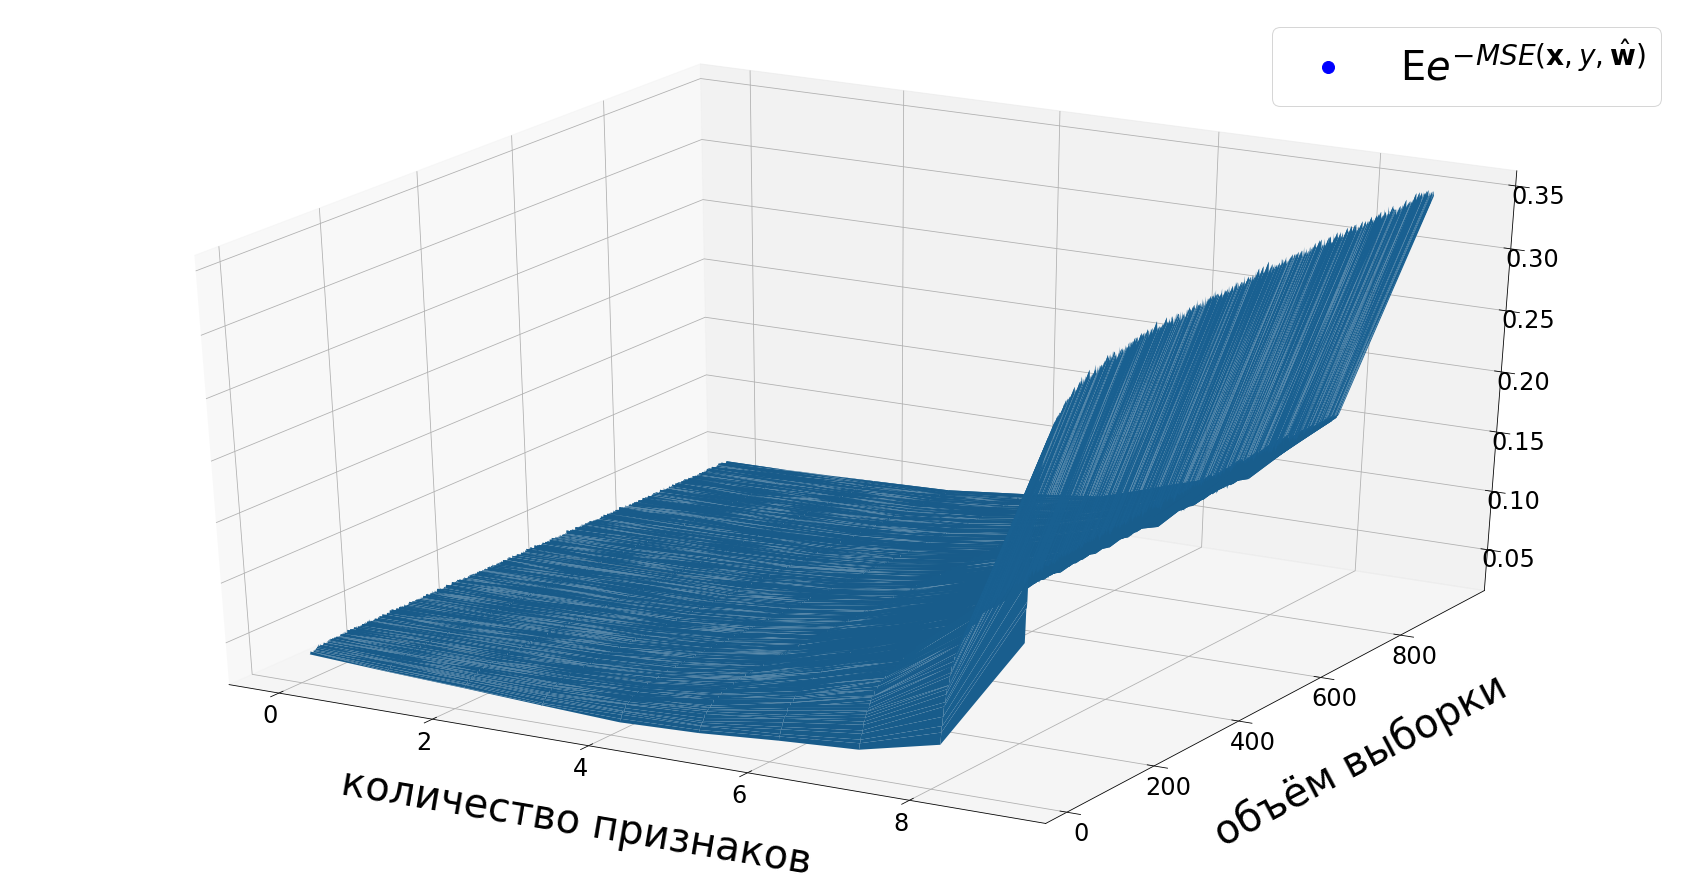

In [36]:
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XX, YY, ZZ, rcount=500, ccount=500)
# ax.plot_surface(XX, YY, ZZ_down, cmap=cm.Reds, alpha=0.3, rcount=500, ccount=500)
# ax.plot_surface(XX, YY, ZZ_up, cmap=cm.Reds, alpha=0.3, rcount=500, ccount=500)
plt.xlabel('количество признаков', labelpad=50)
plt.ylabel('объём выборки', labelpad=50)

label_mean = lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
# label_interval = lines.Line2D([0],[0], linestyle="none", c='r', marker = 'o')
ax.legend([label_mean], ['$\mathsf{E}e^{-MSE(\\mathbf{x}, y, \\hat{\\mathbf{w}})}$'], numpoints = 1)
# plt.savefig('../data/pics/synthetic_MSE_surface.pdf', format='pdf')

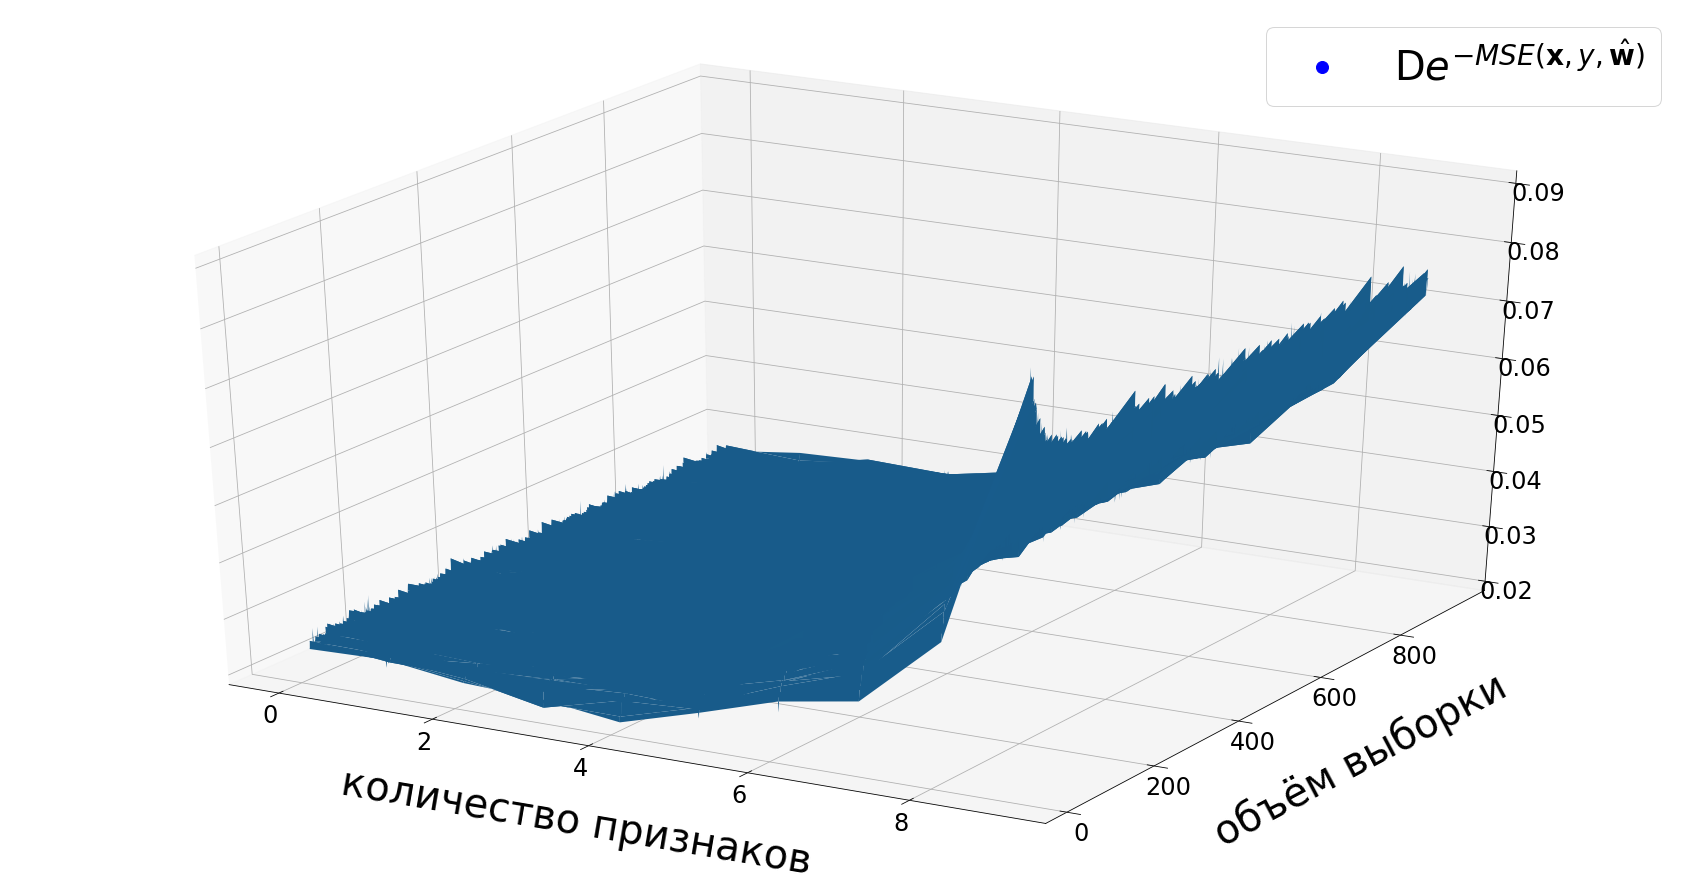

In [37]:
fig = plt.figure(figsize=(30, 16))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(XX, YY, std[:, 10:].T, rcount=500, ccount=500)
plt.xlabel('количество признаков', labelpad=50)
plt.ylabel('объём выборки', labelpad=50)

label_mean = lines.Line2D([0],[0], linestyle="none", c='b', marker = 'o')
ax.legend([label_mean], ['$\mathsf{D}e^{-MSE(\\mathbf{x}, y, \\hat{\\mathbf{w}})}$'], numpoints = 1)
# plt.savefig('../data/pics/synthetic_MSE_std_surface.pdf', format='pdf')

In [17]:
W = []

for j in tqdm(range(N)):

    X_j = X[:, alpha_threshold[:j + 1, 1].astype(np.int32)]
    y_j = y
    
    cov = []

    for m in tqdm(range(10, M)):
    
        W_cur = []

        for i in range(bootstrap_num_iter):
            idx = np.random.choice(M, size=m, replace=False)

            X_m = X_j[idx]
            y_m = y_j[idx]
            
            statmodel = ut.define_model(y_m)
            
            w_hat_j = ut.get_params(X_m, y_m)
            w_hat = np.zeros(N)
            for num, idx in enumerate(alpha_threshold[:j + 1, 1].astype(np.int32)):
                w_hat[idx] = w_hat_j[num]
            
            w_hat.resize((1, N))
            W_cur.append(w_hat)

        W_cur = np.asarray(W_cur)
        
        cur_cov = np.zeros((N, N))
    
        for i in range(bootstrap_num_iter):
            cur_cov += W_cur[i].T @ W_cur[i]
        
        cov.append(cur_cov / (bootstrap_num_iter - 1))
        
    cov = np.asarray(cov)
        
    W.append(cov)
    
W = np.asarray(W)

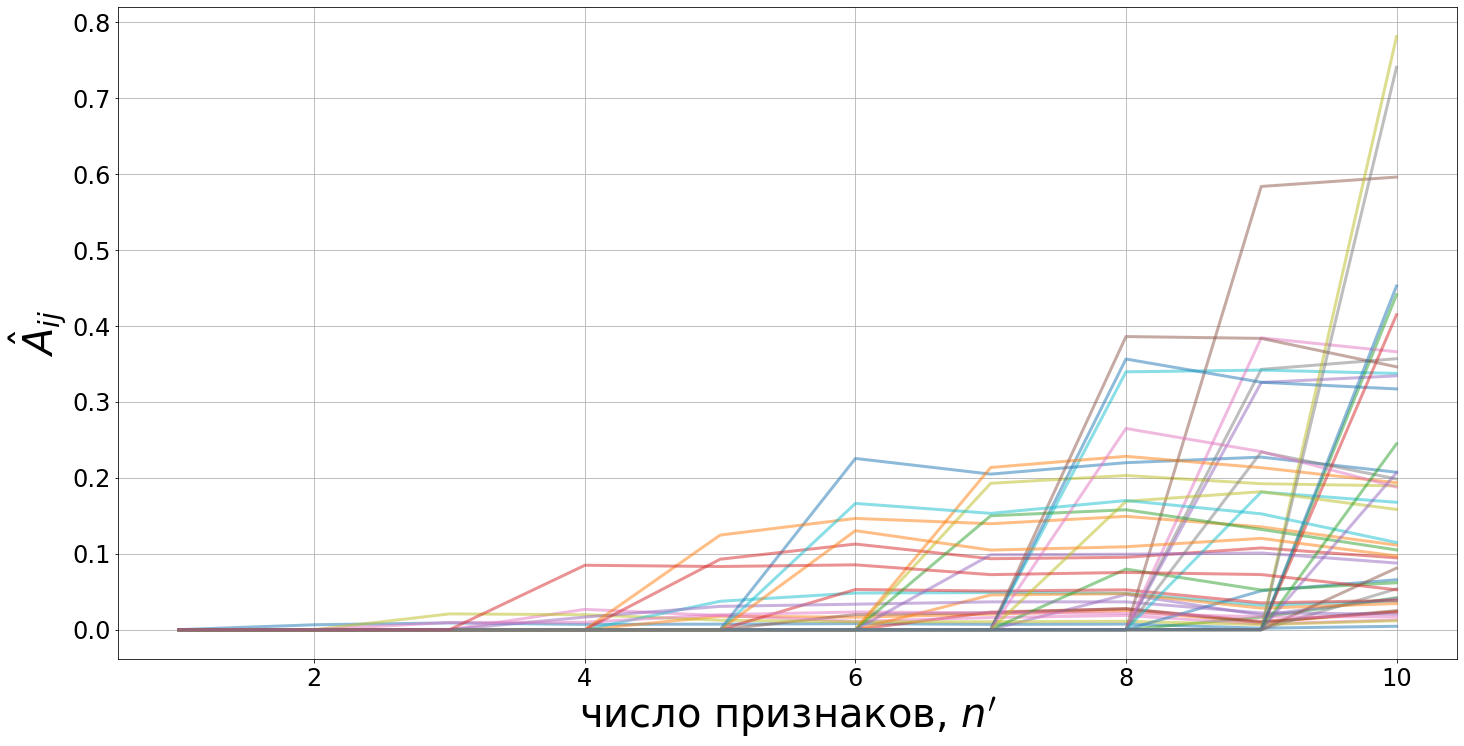

In [19]:
for i in range(N):
    for j in range(i + 1, N):
        plt.plot(np.arange(1, N + 1), W[:, 100, i, j], alpha=0.5, label='$cov_m(w_{}, w_{})$'.format(i, j))
        
plt.grid()
plt.xlabel('число признаков, $n^{\prime}$')
plt.ylabel('$\hat{A}_{ij}$')
plt.savefig('../data/pics/synthetic_W_from_N.pdf', format='pdf')
plt.show()

---
То же самое, от $\tau$.

In [14]:
from sklearn.linear_model import Lasso

W = []

alphas = np.arange(0.01, 2, 0.1)

for alpha in tqdm(alphas):

    cov = []

    for m in tqdm(range(10, M)):
    
        W_cur = []

        for i in range(bootstrap_num_iter):
            idx = np.random.choice(M, size=m, replace=False)

            X_m = X[idx]
            y_m = y[idx]
            
            lm = Lasso(alpha=alpha)
            
            lm.fit(X_m, y_m)
            
            w_hat = lm.coef_
            w_hat.resize((1, N))
            W_cur.append(w_hat)

        W_cur = np.asarray(W_cur)
        
        cur_cov = np.zeros((N, N))
    
        for i in range(bootstrap_num_iter):
            cur_cov += W_cur[i].T @ W_cur[i]
        
        cov.append(cur_cov / (bootstrap_num_iter - 1))
        
    cov = np.asarray(cov)
        
    W.append(cov)
    
W = np.asarray(W)

/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044998982255322235, tolerance: 0.005950494525523912
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.014715828960092124, tolerance: 0.0030845798906355693
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024274270706158396, tolerance: 0.004393279836868648
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00411880709734519, tolerance: 0.0033485586569281427
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01708161685027676, tolerance: 0.0061310929913721765
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.023451773214662075, tolerance: 0.0031733973131317966
  positive)
/home/coder/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to i

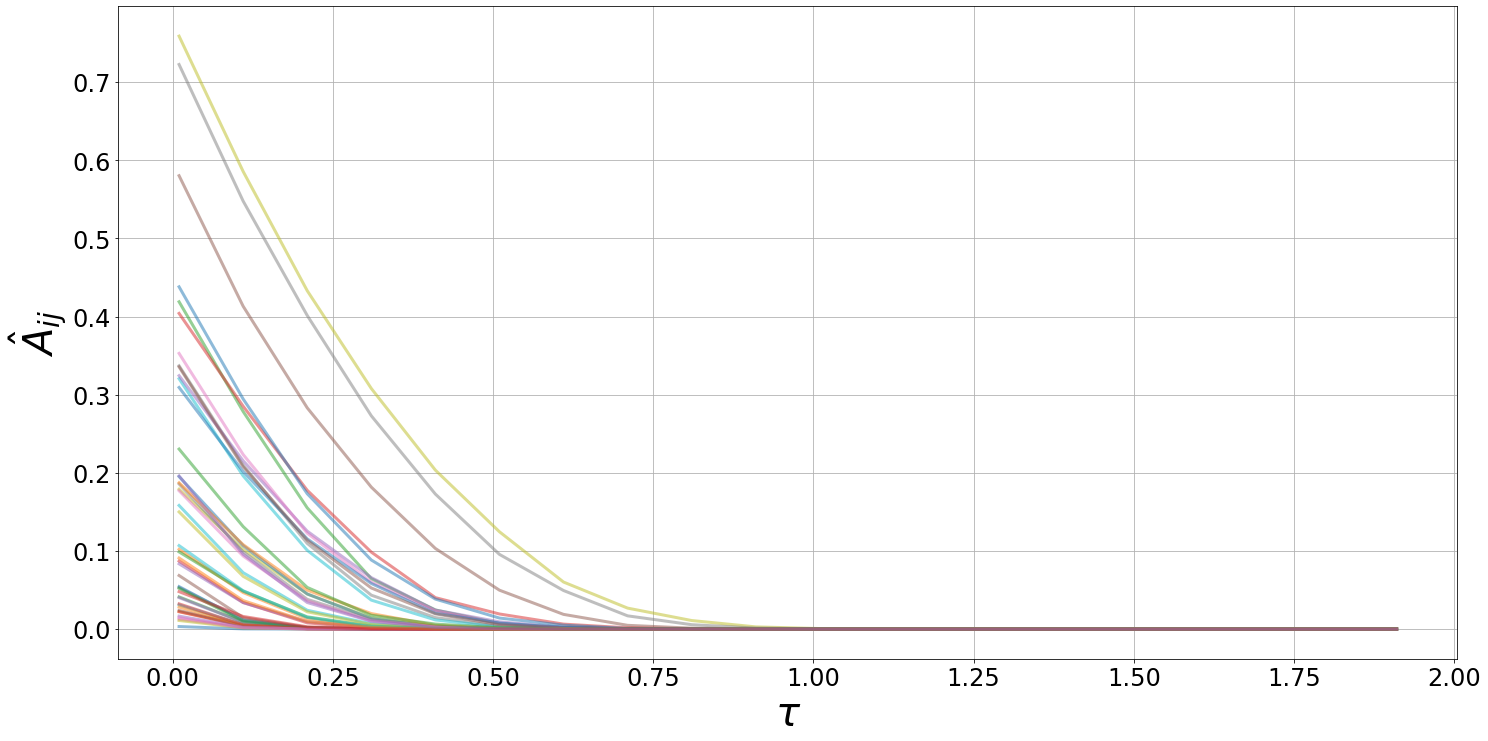

In [16]:
for i in range(N):
    for j in range(i + 1, N):
        plt.plot(alphas, W[:, 100, i, j], alpha=0.5, label='$cov_m(w_{}, w_{})$'.format(i, j))
        
plt.grid()
plt.xlabel('$\\tau$')
plt.ylabel('$\hat{A}_{ij}$')
# plt.savefig('../data/pics/synthetic_W_from_tau.pdf', format='pdf')
plt.show()